# Forecasting Implementation using AutoML - H20.ai

In [2]:
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/flow.html
# Note: Instead of level data, water demand data is currently used to demonstrarte the application of AutoML using H2O.
# Upload the time series data --- > Univariate data
# from google.colab import files
# uploaded = files.upload()

In [5]:
# Data preprocessing
from pandas import read_csv
import pandas as pd
dataset = read_csv('datasets/Hillsborough.csv',header='infer',index_col=0)
dataset.head()

,Demand (MLD)
Time,
01-03-2012 00:00,108.811323
01-03-2012 01:00,123.998979
01-03-2012 02:00,133.331252
01-03-2012 03:00,142.121897
01-03-2012 04:00,138.773395


In [6]:
# Check if all data are numeric
import numpy as np
dataset.applymap(np.isreal).all(1)

# Check if any data is non-nemric
dataset[~dataset.applymap(np.isreal).all(1)]

,Demand (MLD)
Time,


In [8]:
#Convert to float
dataset['Demand (MLD)'] = dataset['Demand (MLD)'].astype('float')
dataset.index.name = 'Time'
print(dataset.head(5))

# save to file
# dataset.to_csv('Hillsborough2.csv')

                  Demand (MLD)
Time                          
01-03-2012 00:00    108.811323
01-03-2012 01:00    123.998979
01-03-2012 02:00    133.331252
01-03-2012 03:00    142.121897
01-03-2012 04:00    138.773395


In [7]:
# !pip install h2o 

In [10]:
import h2o
from h2o.automl import H2OAutoML

import matplotlib.pyplot as plt
from scipy import stats

In [11]:
# Define the supervised learning framework
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame 
from pandas import concat

def series_to_supervised(data, seasonality = 3*24 , n_out=[1], dropnan=True):   # --------------------------->
      n_in = seasonality
      n_vars = 1 if type(data) is list else data.shape[1]
      df = DataFrame(data)
      cols, names = list(), list()
# input sequence (t-n, ... t-1)
      for i in range(0,n_in,1):
            cols.append(df.iloc[:,0].shift(i))
            names += [('var(t-%d)' % (i))]
            # forecast sequence (t, t+1, ... t+n)
      for i in range(1, n_out+1):
            cols.append(df.iloc[:,0].shift(-i))
            names += [('var(t+%d)' % (i))]
      
      # put it all together
      agg = concat(cols, axis=1)
      agg.columns = names
      	# drop rows with NaN values
      if dropnan:
        agg.dropna(inplace=True)
      return agg

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense , Dropout
from keras.layers import LSTM

# load dataset
dataset = read_csv('Hillsborough2.csv', header=0, index_col=0)
values = dataset.values

# ensure all data is float
values = values.astype('float32')

# frame as supervised learning
reframed = series_to_supervised(values,3*24, 1) # -----------------------------------> 
# Convert to dataframe
df_reframed = pd.DataFrame(reframed)
df_reframed.reset_index(drop=True,inplace=True)
# split into train and test sets
df_train = df_reframed.loc[:int(df_reframed.shape[0]*0.8),:]
df_test = df_reframed.loc[int(df_reframed.shape[0]*0.8):,:]

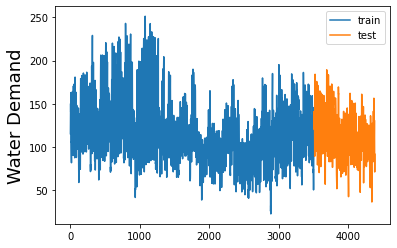

In [36]:
#Plot data
plt.plot(df_train.index,df_train['var(t+1)'])
plt.plot(df_test.index,df_test['var(t+1)'])
plt.ylabel('Water Demand',fontsize=18)
plt.legend(['train','test'])
plt.show()

In [13]:
# Initialize H2O thread
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.311-b11, mixed mode)
  Starting server from C:\Users\rvanipenta.HDS\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\RVANIP~1.HDS\AppData\Local\Temp\tmpavw946hy
  JVM stdout: C:\Users\RVANIP~1.HDS\AppData\Local\Temp\tmpavw946hy\h2o_rvanipenta_started_from_python.out
  JVM stderr: C:\Users\RVANIP~1.HDS\AppData\Local\Temp\tmpavw946hy\h2o_rvanipenta_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_rvanipenta_kbnwux
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.524 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [14]:
# Convert to H2O Frames
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
y = 'var(t+1)'
X = hf_train.columns
X.remove(y)

In [16]:
aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42)
aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |
11:15:26.306: AutoML: XGBoost is not available; skipping it.
11:15:26.356: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
11:15:26.356: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_1_20220118_111526

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 14.9857120364877
RMSE: 3.8711383385882376
MAE: 2.957345896360784
RMSLE: 0.0368705568206059
R^2: 0.9884021246428646
Mean Residual Deviance: 14.9857120364877
Null degrees of freedom: 3508
Residual degrees of freedom: 3499
Null deviance: 4534008.334869706
Residual deviance: 52584.86353603534
AIC: 19479.314757871096

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 54.30214

In [17]:
leader_model = aml.leader
hf_test_predict = leader_model.predict(hf_test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [18]:
hf_test_predict.head(5)

predict
143.608
135.526
124.773
112.678
112.952


In [19]:
y_act = df_test['var(t+1)'].values
y_predict = h2o.as_list(hf_test_predict)
y_predict = y_predict.values

In [20]:
# calculate RMSE
rmse = sqrt(mean_squared_error(y_act, y_predict))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 7.016


In [21]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE = mean_absolute_percentage_error(y_act,y_predict)
print('Test MAPE: %.3f' % MAPE)

Test MAPE: 29.629


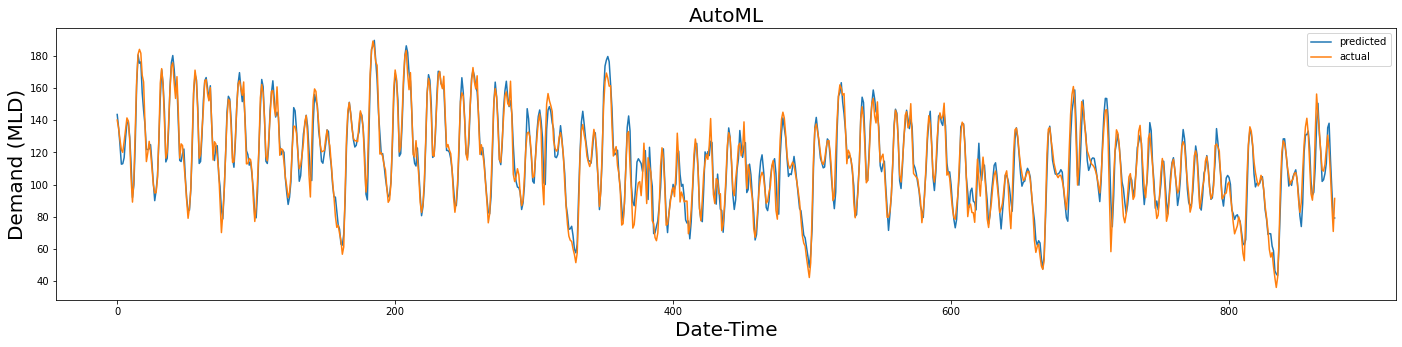

In [22]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(24, 5))

ax.set_title('AutoML',fontsize=20)
ax.set_xlabel('Date-Time',fontsize=20)
ax.set_ylabel('Demand (MLD)',fontsize=20)

# ax.plot(series.index[:(24*30)],y1)
plt.plot(y_predict, label = 'predicted')
plt.plot(y_act, label = 'actual')
plt.legend()